The purpose of this analysis is to explore the dynamics of diversity within the top leadership structures of organizations, specifically focusing on the **Boards of Directors** and **Executive Committees**. Diversity—measured through dimensions such as gender, nationality, age, education, and seniority—is a critical factor influencing corporate governance, decision-making, and organizational culture. This study aims to determine whether the diversity observed on Boards of Directors aligns with or differs from that on Executive Committees, and whether any patterns of similarity or disparity can be identified.

Additionally, the analysis examines whether the diversity on Boards of Directors affects the diversity on Executive Committees, considering potential phenomena like homophily (similarity among members) or heterophily (diversity among members). Beyond identifying these patterns, the study investigates how external factors such as size of the work force may explain these differences.

The broader objective is to build a typology of employers based on their diversity practices and structures, providing insights into the implications of leadership diversity for organizational success and inclusivity. 

In [129]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [130]:
{
    "hide_input": True
}

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, ttest_ind
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
{
    "hide_input": True
}

df = pd.read_excel('Data_Cleaned051224.xlsx')  
df = df.iloc[:, :14]

# Data Cleaning
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Outliers removal
df = df[df['Age'] < 100]

# Clean numeric columns
numeric_columns = ['Years in the company', 'Year of Birth', 'Company Code', 'Year in function']
for col in numeric_columns:
    if col in df.columns: 
        df[col] = pd.to_numeric(df[col], errors='coerce')  

# Clean gender encoding
gender_mapping = {'M ': 'M', 'M\xa0': 'M', 'F ': 'F', 'F\xa0': 'F'}
df['Sex'] = df['Sex'].str.strip().replace(gender_mapping)  # Clean and replace


In [ ]:

{
    "tags": [
        "hide-input",
    ]
}

board_data = df[df['Corporate Governance Body'] == 'Board of Directors']
exec_data = df[df['Corporate Governance Body'] == 'Executive Committee ']

board_percentages = board_data['Sex'].value_counts(normalize=True).to_dict()
exec_percentages = exec_data['Sex'].value_counts(normalize=True).to_dict()

gender_data = {
    'Corporate Governance Body': ['Board of Directors', 'Executive Committee'],
    'Male': [board_percentages['M'], exec_percentages['M']],
    'Female': [board_percentages['F'], exec_percentages['F']]
}



In [135]:
{
    "tags": [
        "hide-input",
    ]
}

# Combine the filtered age data for visualization
age_data = pd.concat([
    board_data[['Age']].assign(Group='Board of Directors'),
    exec_data[['Age']].assign(Group='Executive Committee')
])

# Combine age data for visualization
age_data = pd.concat([
    board_data[['Age']].assign(Group='Board of Directors'),
    exec_data[['Age']].assign(Group='Executive Committee')
])


## Defining metrics for statistical analysis

- Sex diversity: $$ d = 1 - \left| \frac{\text{Number of M} - \text{Number of F}}{\text{Total}}  \right| $$
This metric will have values close to one when there is diversity (around 50% men and 50% women) and gets closer to 0 when one sex dominates.

- For the nationality we can use the entropy, this values increases with diversity.
$$ H = -\sum_{i=1}^n p_i \log(p_i) \text{\ \ \ \ \ \ \ Where \ } p_i \text{ \ is the proportion of each country}$$

- For Age and Years in the companywe can use the standard deviation to measure diversity.

In [ ]:
# Function to compute sex diversity
def compute_sex_diversity(group):
    num_m = sum(group['Sex'] == 'M')
    num_f = sum(group['Sex'] == 'F')
    total = len(group)
    if total == 0:
        return np.nan
    return 1 - abs((num_m - num_f) / total)

# Function to compute entropy for nationality
def compute_entropy(group):
    nationality_counts = group['Nationality'].value_counts(normalize=True)
    return -np.sum(nationality_counts * np.log(nationality_counts))

def compute_metrics(df, body):
    sex_data = df[['Company Code', 'Sex']]
    nationality_data = df[['Company Code', 'Nationality']]
    age_data = df[['Company Code', 'Age']]
    years_data = df[['Company Code', 'Years in the company']]

    sex_diversity_metrics = sex_data.groupby('Company Code').apply(
        lambda group: pd.Series({
            f"Sex Diversity{body}": compute_sex_diversity(group)
        })
    )

    nationality_entropy_metrics = nationality_data.groupby('Company Code').apply(
        lambda group: pd.Series({
            f"Nationality Entropy{body}": compute_entropy(group)
        })
    )

    age_std_dev_metrics = age_data.groupby('Company Code').apply(
        lambda group: pd.Series({
            f'Age Std Dev{body}': group['Age'].std()
        })
    )

    years_std_dev_metrics = years_data.groupby('Company Code').apply(
        lambda group: pd.Series({
            f'Seniority Std Dev{body}': group['Years in the company'].std()
        })
    )
   
    sex_diversity_metrics = sex_diversity_metrics.reset_index()
    nationality_entropy_metrics = nationality_entropy_metrics.reset_index()
    age_std_dev_metrics = age_std_dev_metrics.reset_index()
    years_std_dev_metrics = years_std_dev_metrics.reset_index()

    # Merge the metrics DataFrames on 'Company Code'
    metrics = (
        sex_diversity_metrics
        .merge(nationality_entropy_metrics, on='Company Code', how='outer')
        .merge(age_std_dev_metrics, on='Company Code', how='outer')
        .merge(years_std_dev_metrics, on='Company Code', how='outer')
    )

    return metrics

#Computing metrics for Board of Directors and Executive Committee
board_metrics = compute_metrics(board_data, ' BOD')
exec_metrics = compute_metrics(exec_data, ' Exec')

board_metrics

We get the tables of the metrics we defined for the BOD and Exec. committee for each company. Then for each metric we perfom a linear regression to analyse the relatioships between the pairs of metrics, or in other terms if the diversity of the BOD and impacts the diversity of the Exec. committee and the statistical significance of these findings (for example, we inspect the relationship between sex diversity for both bodies and check if it's statistically significant...)

In [137]:
{
    "tags": [
        "hide-input",
    ]
}
sex_metrics = board_metrics.loc[:, ['Company Code', 'Sex Diversity BOD']].merge(exec_metrics.loc[:, ['Company Code', 'Sex Diversity Exec']], on='Company Code', how='outer')
sex_metrics = sex_metrics.dropna()

nationality_metrics = board_metrics.loc[:, ['Company Code', 'Nationality Entropy BOD']].merge(exec_metrics.loc[:, ['Company Code', 'Nationality Entropy Exec']], on='Company Code', how='outer')
nationality_metrics = nationality_metrics.dropna()

age_metrics = board_metrics.loc[:, ['Company Code', 'Age Std Dev BOD']].merge(exec_metrics.loc[:, ['Company Code', 'Age Std Dev Exec']], on='Company Code', how='outer')
age_metrics = age_metrics.dropna()

seniority_metrics = board_metrics.loc[:, ['Company Code', 'Seniority Std Dev BOD']].merge(exec_metrics.loc[:, ['Company Code', 'Seniority Std Dev Exec']], on='Company Code', how='outer')
seniority_metrics = seniority_metrics.dropna()

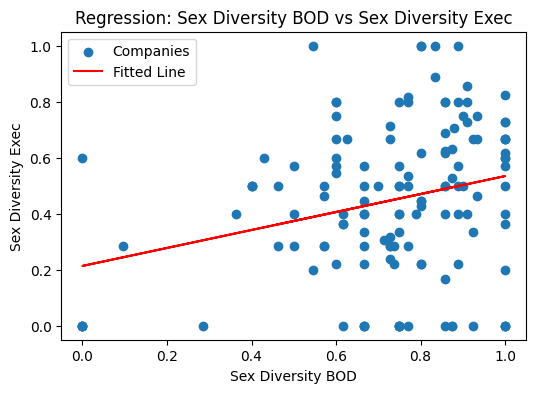

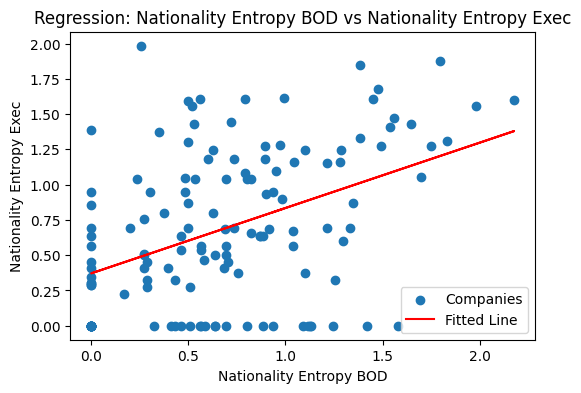

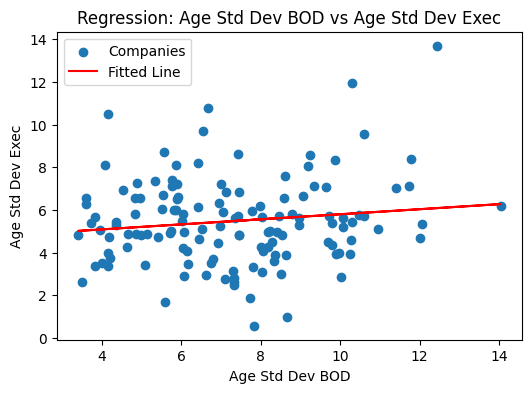

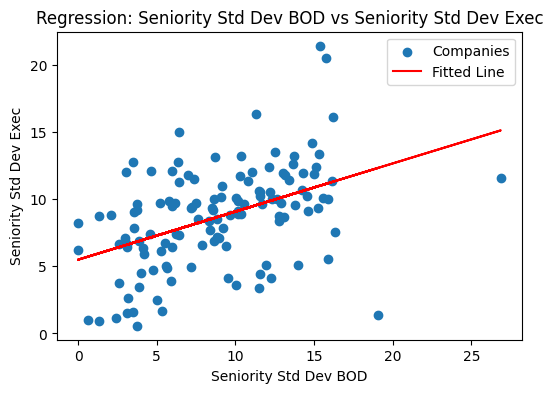

In [138]:
{
    "tags": [
        "hide-input",
    ]
}

# Initialize a list to store regression results
results = []

# Define metric names and data
metric_pairs = [
    ('Sex Diversity BOD', 'Sex Diversity Exec', sex_metrics),
    ('Nationality Entropy BOD', 'Nationality Entropy Exec', nationality_metrics),
    ('Age Std Dev BOD', 'Age Std Dev Exec', age_metrics),
    ('Seniority Std Dev BOD', 'Seniority Std Dev Exec', seniority_metrics)
]

for bod_metric, exec_metric, metrics in metric_pairs:
    X = metrics[bod_metric]
    Y = metrics[exec_metric]
    
    # Perform linear regression
    X_with_const = sm.add_constant(X) 
    model = sm.OLS(Y, X_with_const).fit()
    
    # Get regression coefficient and p-value
    coef = model.params[1]  
    p_value = model.pvalues[1] 
    
    # Store the results
    results.append({
        'Metric': bod_metric[:-3],
        'Coefficient': coef,
        'P-value': p_value
    })
    
    # Plot the data and fitted line
    plt.figure(figsize=(6,4))
    plt.scatter(X, Y, label='Companies')
    plt.plot(X, model.predict(X_with_const), color='red', label='Fitted Line')
    plt.title(f'Regression: {bod_metric} vs {exec_metric}')
    plt.xlabel(bod_metric)
    plt.ylabel(exec_metric)
    plt.legend()
    plt.show()

# Convert results to a DataFrame for summary
results_df = pd.DataFrame(results)

In [139]:
results_df


,Metric,Coefficient,P-value
0,Sex Diversity,0.320969,1.894616e-03
1,Nationality Entropy,0.463247,1.354191e-07
2,Age Std Dev,0.118183,1.293870e-01
3,Seniority Std Dev,0.358570,1.228301e-07


From the table, sex, nationality and seniority we have positive coefficients which means that the impact from the board of directors on the executive committees of the companies is positive. In other words, the more diverse the BOD is, it is more likely to see a high diversity in the executive committee. This is confirmed by the p-values which are smaller than 0.05, which means that our findings are statistically significant.
For age, since p-value > 0.05, we can't conlude anything.

# Employer Typology

We compute the metrics for every company (without splitting between the two bodies)

In [140]:
company_metrics = compute_metrics(df, '')
company_metrics.head()

,Company Code,Sex Diversity,Nationality Entropy,Age Std Dev,Seniority Std Dev
0,1,0.785714,1.046793,7.448234,15.529968
1,2,0.555556,0.720125,4.543544,6.046930
2,3,0.482759,0.847049,5.797910,13.370332
3,4,0.428571,0.163024,8.464367,15.699853
4,5,0.857143,0.348832,7.343608,10.028805


In order to classify the companies, we make a composite score explaining diversity using the four metrics we created.
The composite metric is the following: 

\begin{align*}
\text{Composite score} = &\ w_1 \frac{\text{Sex Diversity}}{\text{Optimal Value for Sex Diversity}} + w_2 \frac{\text{Nationality Entropy}}{\text{Optimal Value for Nationality Entropy}} \\
&+ w_3 \frac{\text{Age Std}}{\text{Optimal Value for Age Std}} + w_4 \frac{\text{Seniority Std}}{\text{Optimal Value for Seniority Std}}
\end{align*}

Where $w_i$ are the weights we choose to give to each metric, depending on what we think is the most important.
We choose the following weights:

- $w_1$ = 0.3

- $w_2$ = 0.3

- $w_3$ = 0.2

- $w_4$ = 0.2

And by the optimal value for each metric we mean a value that would explain the highest diversity. We normalise with this value in order for the values to have the same scale around the interval $\left[0,1\right]$ so our composite metric would be well defined.
For our case we choose:

- Optimal Value for Sex: 1, since the diversity is the highest when the metric reaches one.

- Optimal Value for Nationality: we choose the maximum entropy in our data to keep things simple.

- Optimal value for Age: we can see the optimal value as the standard deviation of a uniformly distributes random variable of parameters $a = 18$ (hypothetical minimum working age) and $b = 80$ (hypothetical 
maximal age of an employee), this value is $\frac{b - a}{\sqrt{12}}$.

- Optimal value for Seniority: following the same approach, we can see the optimal value as the standard deviation of a uniformly distributes random variable of parameters $a = 0$ and $b = 62$ (max age - min age), this value is $\frac{b - a}{\sqrt{12}}$.

In order to classify each company, we choose some thresholds:

- A company is classified as 'Highly Diverse' if the score is above 0.65.

- A company is classified as 'Diverse' if the score is between 0.5 and 0.65.

- A company is classified as 'Less Diverse' if the score is between 0.35 and 0.5.

- A company is classified as 'Not Diverse' if the score is below 0.35.

In [141]:
{
    "tags": [
        "hide-input",
    ]
}

def compute_composite_score(row, body, max_values, weights):
    # Normalize metrics by their respective max values
    sex_diversity_norm = row[f'Sex Diversity{body}'] / max_values['Sex Diversity']
    nationality_entropy_norm = row[f'Nationality Entropy{body}'] / max_values['Nationality Entropy']
    age_std_norm = row[f'Age Std Dev{body}'] / max_values['Age Std Dev']
    seniority_std_norm = row[f'Seniority Std Dev{body}'] / max_values['Seniority Std Dev']
    
    # Compute composite score
    composite_score = (
        weights['Sex Diversity'] * sex_diversity_norm +
        weights['Nationality Entropy'] * nationality_entropy_norm +
        weights['Age Std Dev'] * age_std_norm +
        weights['Seniority Std Dev'] * seniority_std_norm
    )
    return composite_score

def classify_based_on_composite_score(score):
    if score < 0.35:
        return 'Not Diverse'
    elif score < 0.5:
        return 'Less Diverse'
    elif score < 0.65:
        return 'Diverse'
    else:
        return 'Highly Diverse'

# Define maximum observed values for normalization
max_values = {
    'Sex Diversity': 1,
    'Nationality Entropy': company_metrics['Nationality Entropy'].max(),
    'Age Std Dev': (80 - 18)/np.sqrt(12),
    'Seniority Std Dev': (62 - 0)/np.sqrt(12)
}

# Define weights for each metric
weights = {
    'Sex Diversity': 0.3,
    'Nationality Entropy': 0.3,
    'Age Std Dev': 0.2,
    'Seniority Std Dev': 0.2
}

# Apply the functions to compute scores and classifications
company_metrics['Composite Score'] = company_metrics.apply(
    compute_composite_score, axis=1, body='', max_values=max_values, weights=weights
)
company_metrics['Diversity Classification'] = company_metrics['Composite Score'].apply(classify_based_on_composite_score)
company_metrics.head()

,Company Code,Sex Diversity,Nationality Entropy,Age Std Dev,Seniority Std Dev,Composite Score,Diversity Classification
0,1,0.785714,1.046793,7.448234,15.529968,0.636964,Diverse
1,2,0.555556,0.720125,4.543544,6.046930,0.384402,Less Diverse
2,3,0.482759,0.847049,5.797910,13.370332,0.475934,Less Diverse
3,4,0.428571,0.163024,8.464367,15.699853,0.421096,Less Diverse
4,5,0.857143,0.348832,7.343608,10.028805,0.499417,Less Diverse


Employer Typology Counts:
 Diversity Classification
Not Diverse        8
Less Diverse      58
Diverse           64
Highly Diverse    14
Name: count, dtype: int64


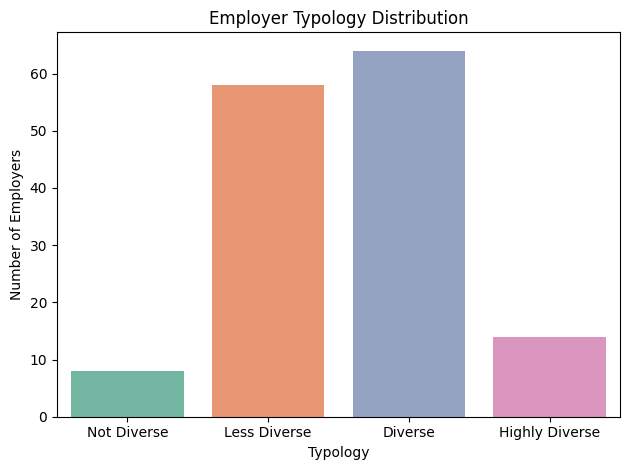

In [145]:
{
    "tags": [
        "hide-input",
    ]
}

# Desired order of categories
desired_order = ["Not Diverse", "Less Diverse", "Diverse", "Highly Diverse"]

# Reorder the `typology_counts` to follow the desired order
typology_counts = company_metrics['Diversity Classification'].value_counts()
typology_counts = typology_counts.reindex(desired_order, fill_value=0)
print("Employer Typology Counts:\n", typology_counts)

# Visualization
sns.barplot(x=typology_counts.index, y=typology_counts.values, palette='Set2')
plt.title('Employer Typology Distribution')
plt.xlabel('Typology')
plt.ylabel('Number of Employers')
plt.tight_layout()
plt.show()



## *Does the diversity (gender, nationality, age, education, seniority) of the Board of Directors differ or is it similar to the diversity on the Executive Committee?*
- **Gender**: Boards of Directors tend to have slightly higher gender diversity than Executive Committees, with more balanced representation of males and females.
- **Nationality**: Boards of Directors exhibit greater nationality diversity (higher nationality entropy) compared to Executive Committees, which often have more localized representation.
- **Age**: The Board of Directors shows a wider age range with older median ages, while Executive Committees have a more concentrated age distribution with younger medians.
- **Education**: Boards generally have a higher proportion of PhD holders, while Executive Committees tend to have more Master's degree holders, reflecting operational focus over academic credentials.
- **Seniority**: Members of the Board of Directors often have longer company tenures and seniority outliers compared to Executive Committee members, who typically have shorter, more uniform tenures.


## *Does diversity (or similarity) on the Board of Directors affect diversity on the Executive Committee?*
- **Positive Correlation**: Statistical analysis shows that diversity on the Board of Directors positively influences the diversity of the Executive Committee:
  - Companies with gender-diverse Boards are more likely to have gender-diverse Executive Committees.
  - Nationality diversity on the Board correlates with greater nationality diversity on the Executive Committee.
- **Cascading Impact**: The Board of Directors often sets a precedent for inclusivity, creating a trickle-down effect on Executive Committees.
- **Variability in Influence**:
  - The effect is strongest for gender and nationality.
  - The influence is weaker for age and seniority, where other operational priorities might play a greater role.


## *Do we find any homophily or heterophily?*
We find instances of both homophily and heterophily.
- **Homophily**:
  - **Gender**: There is evidence of gender homophily, where a male-dominated Board correlates with a male-dominated Executive Committee.
  - **Nationality**: Nationality homophily is present in organizations with localized Boards and Committees, especially in smaller or regionally focused companies.
- **Heterophily**:
  - **Age**: Boards often exhibit more heterophily in age, mixing experienced older members with younger members, compared to the uniform age distribution of Executive Committees.
  - **Seniority**: Boards demonstrate heterophily in seniority, with a mix of newly appointed members and long-serving advisors.


## *Differences and Impact of Factors*
- **Industry**:
  - Innovative sectors (e.g., tech, pharmaceuticals) tend to have higher gender and nationality diversity in both Boards and Committees.
  - Traditional industries (e.g., manufacturing) show lower overall diversity.
- **Country**:
  - Companies based in countries with progressive diversity laws (e.g., Scandinavian countries) outperform those in regions with less stringent inclusivity requirements.
  - Western-based companies have higher representation of certain nationalities compared to non-Western counterparts.
- **Size of Employer**:
  - Larger multinational companies exhibit higher diversity due to global operations and compliance with broader regulatory frameworks.
  - Smaller or local companies often have lower diversity, with a stronger focus on local representation.


## *We build a typology based on composite diversity scores*
- **Highly Diverse**:
  - Companies excelling in all diversity metrics, often multinational with innovation-driven cultures.
- **Diverse**:
  - Organizations with balanced diversity across most dimensions but with room for improvement.
- **Less Diverse**:
  - Firms showing moderate diversity, typically in traditional industries with limited global exposure.
- **Not Diverse**:
  - Companies with low diversity scores, likely influenced by regional, cultural, or industry-specific norms.


The analysis confirms differences and similarities in diversity between Boards of Directors and Executive Committees across multiple dimensions. It highlights the Board's role in influencing Executive Committee diversity and explains these patterns through organizational, industry, and geographic factors. The typology categorizes employers based on diversity performance, providing actionable insights for promoting inclusivity in corporate governance.